# Phase retrieval using unrolled networks

In [1]:
import torch 
import torchvision as tv

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.nn as nn

from tqdm.notebook import tqdm
from skimage import metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2
print(torch.__version__, tv.__version__, np.__version__)

1.9.0+cu102 0.10.0+cu102 1.21.0


# Define the recurrent network for Phase retrieval

## A single layer to compute the true measurements and initialize the reconstructions

In [2]:
class InitialLayer(nn.Module):
    def __init__(self):
        super(InitialLayer, self).__init__()
        
    def forward(self, x_gt, u):
        
        # for numerical stability
        eps = torch.tensor([1e-15])
        
        #unpack
        n, h, w = x_gt.size()
        
        # true signal measurement
        y = torch.fft.fft2(x_gt + u + eps, s=(2*h, 2*w), norm='ortho').abs()
        
        # init reconstruction 
        x = torch.zeros_like(x_gt, requires_grad=True)
        
        return x, y.requires_grad_(True), u.requires_grad_(True)

## Gradient descent layers which perform the update step with SGD

In [3]:
class GradientDescentLayer(nn.Module):
    def __init__(self):
        super(GradientDescentLayer, self).__init__()

    def forward(self, xk, y, u, alpha):

        # for numerical stability
        eps = torch.tensor([1e-15])
        
        #unpack
        n, h, w = xk.size()

        # compute estimated signal
        y_est = torch.fft.fft2(xk + u + eps, s=(2*h,2*w), norm='ortho').abs()

        # measurement loss
        loss = (y - y_est).pow(2).sum()

        # update reconstruction via SGD
        loss.backward(retain_graph= True)
        new_x = xk - alpha * xk.grad.data
        new_x = torch.clamp(new_x, 0, 1)

        return new_x.clone().detach().requires_grad_(True)

## The (trainable) network which composes the initial layer and k - SGD layer together

In [4]:
class UnrolledNetwork(nn.Module):
    def __init__(self, k):
        super(UnrolledNetwork, self).__init__()

        self.num_layer = k
        self.init = InitialLayer()
        self.layer = GradientDescentLayer()

    def forward(self, x_gt, u, alpha, eval=False):
          
        # init reconstruction
        xk, y, uk = self.init(x_gt, u)
        
        # compute reconstructions
        for layer in tqdm(range(self.num_layer)):
             xk = self.layer(xk, y, uk, alpha)
        
        
        if eval is False:
            return xk
        
        # evaluate
        self.__compute_metrics(x_gt, xk.clone())
        
        return xk
    
    def train(self, train_data, alpha, beta, epochs):
        # function to train a reference using this unrolled network
        
        # unpack
        n, h, w = train_data.size()

        # init first reference signal
        torch.manual_seed(417)
        u = torch.rand(h, w, requires_grad=True)

        best_loss = float('inf')
        best_u = u
        for epoch in range(epochs):

            rec = self.forward(train_data, u, alpha)
            loss = (train_data - rec).pow(2).sum()

            if loss.item() < best_loss:
                best_u = u
                best_loss = loss.item()

            print(f' Loss: {loss.item()}')
            plt.gray()
            plt.imshow(u.detach().numpy());
            plt.show()
            
            loss.backward(retain_graph=True)
            new_u = u - beta * u.grad.data
            new_u = torch.clamp(new_u, 0, 1)

            u = new_u.clone().detach().requires_grad_(True)
        
        return best_u.detach()

    def __compute_metrics(self, x_gt, xk):
        # function to compute mean psnr and mean ssim
        psnr = []
        ssim = []
        
        n = x_gt.size()[0]
        gt = x_gt.detach().numpy()
        rec = xk.detach().numpy()
        
        for i in range(n):
            psnr.append(metrics.peak_signal_noise_ratio(gt[i], rec[i]))
            ssim.append(metrics.structural_similarity(gt[i], rec[i]))

        mp, sp = np.mean(psnr), np.std(psnr)
        ms, ss = np.mean(ssim), np.std(ssim)
        
        print(f'PSNR: {mp} +/- {sp}')
        print(f'SSIM: {ms} +/- {ss}')

# Load the test data

In [5]:
CIFAR10_train = tv.datasets.CIFAR10('cifar', train=True, download=True)
CIFAR10_test = tv.datasets.CIFAR10('cifar', train=False, download=True)


ToGrayscale = np.array([[0.2989], [0.5870], [0.1140]])
x_train = np.squeeze(CIFAR10_train.data@ToGrayscale)/255
x_test = np.squeeze(CIFAR10_test.data@ToGrayscale)/255

x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)

Files already downloaded and verified
Files already downloaded and verified


## Train a reference signal

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 1265.708251953125


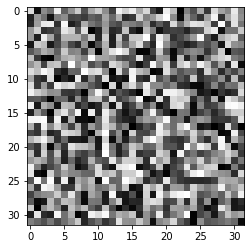

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 25.37702751159668


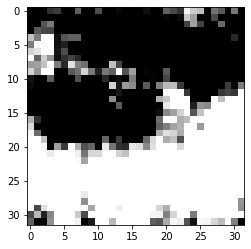

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 25.030925750732422


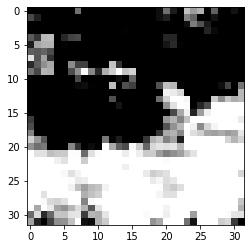

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 37.055294036865234


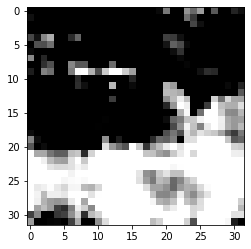

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 46.49266052246094


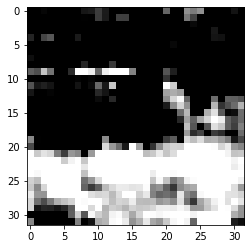

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 56.75692367553711


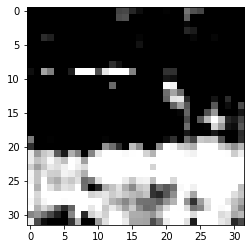

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 36.14095687866211


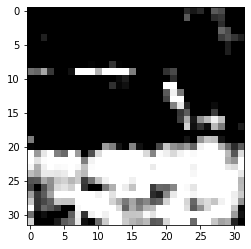

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 73.6795883178711


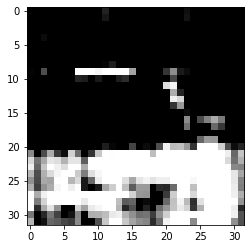

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 52.89167404174805


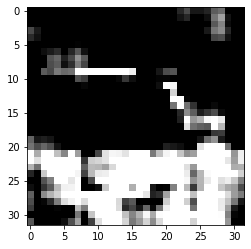

  0%|          | 0/50 [00:00<?, ?it/s]

 Loss: 64.81414031982422


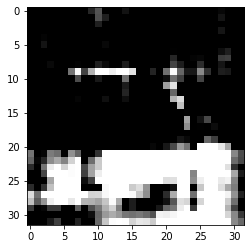

In [7]:
n_train = 32

# create network with 50 layer
net = UnrolledNetwork(k = 50)

# train network
ref = net.train(x_train[:32], alpha = 0.8, beta= 0.1, epochs=10)

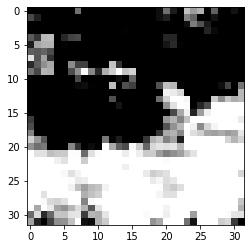

In [8]:
plt.imshow(ref.numpy());

## Test the reference signal for reconstruction

In [9]:
n_test = 10000

net = UnrolledNetwork(50)

rec = net(x_test, ref, 0.8, eval=True)

  0%|          | 0/50 [00:00<?, ?it/s]

PSNR: 42.27349982616841 +/- 12.689637604423648
SSIM: 0.9711456691635773 +/- 0.06587896539166054


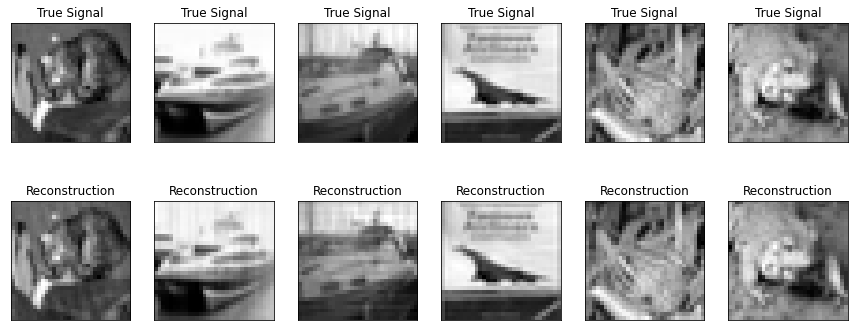

In [10]:
n = 6

height, width = x_test[0].size()
figset = range(0,n)
plt.figure(figsize=(n*2.5, 6))
plt.gray()

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[figset[i]].detach().numpy())
    plt.gray
    plt.title('True Signal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 +n)
    plt.imshow(rec[figset[i]].detach().numpy())
    plt.title('Reconstruction')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)